# 1. Load

# The Problem: 
### Predicting whether a person with a given set of characteristics is likely to have a heart attack.

In [3]:
import pandas as pd
!pwd
df_raw = pd.read_csv("data/heart.csv") 
print("Columns:", df_raw.columns.tolist())

/Users/rosasampaio/Documents/github/data_science_prediction_pacient/final-test
Columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


In [4]:
print(df_raw.head(1))
print("Types :\n",df_raw.dtypes)

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
Types :
 Age                 int64
Sex                   str
ChestPainType         str
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG            str
MaxHR               int64
ExerciseAngina        str
Oldpeak           float64
ST_Slope              str
HeartDisease        int64
dtype: object


# 2. Pré-processamento

In [5]:
print(df_raw.isna())
print("SIZE: ", len(df_raw))

       Age    Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0    False  False          False      False        False      False   
1    False  False          False      False        False      False   
2    False  False          False      False        False      False   
3    False  False          False      False        False      False   
4    False  False          False      False        False      False   
..     ...    ...            ...        ...          ...        ...   
913  False  False          False      False        False      False   
914  False  False          False      False        False      False   
915  False  False          False      False        False      False   
916  False  False          False      False        False      False   
917  False  False          False      False        False      False   

     RestingECG  MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0         False  False           False    False     False         False  

In [6]:
# same the df.shape[0]
df_raw.isna().count()

Age               918
Sex               918
ChestPainType     918
RestingBP         918
Cholesterol       918
FastingBS         918
RestingECG        918
MaxHR             918
ExerciseAngina    918
Oldpeak           918
ST_Slope          918
HeartDisease      918
dtype: int64

In [7]:
df_raw.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Resultado: não existens ausentes

# 3. Normalization

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Normalization
# Apply StandardScaler ONLY to numeric columns.
# And you should NEVER try to transform categorical columns to 0 and 1 before standardizing.
# The same logic applies to OneHotEncoder (categorical columns ONLY)

df_categorical = df_raw.select_dtypes(exclude=['number'])
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(df_categorical)

encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(df_categorical.columns),
    index=df_raw.index
)

# Outliers: Statistical Rule vs. Quality Rule (Domain Violation)
Fundamental Difference (Very Important)

## Statistical Outlier (IQR)
- Extreme but plausible value
- Ex.: Cholesterol = 450
- Action: cap / flag / feature engineering

## Domain Violation (Data Quality)
- Impossible value in the real world
- Ex.: Age = 200
- Action: quality rule, not statistical

*Age = 200 is not an outlier

*Age = 200 is invalid data

# Treat outliers only in the original numeric columns.

In [9]:
df_numeric = df_raw.select_dtypes(include=['number'])
df_numeric.dtypes

Age               int64
RestingBP         int64
Cholesterol       int64
FastingBS         int64
MaxHR             int64
Oldpeak         float64
HeartDisease      int64
dtype: object

In [10]:
print(df_numeric["RestingBP"].value_counts()) 

RestingBP
120    132
130    118
140    107
110     58
150     55
      ... 
174      1
117      1
192      1
129      1
164      1
Name: count, Length: 67, dtype: int64


In [11]:
print(df_numeric["FastingBS"].value_counts()) ## is a binary variable; statistical IQR does not apply.

FastingBS
0    704
1    214
Name: count, dtype: int64


In [12]:
print(df_numeric["Age"].value_counts()) ## It is already numerical not to apply statistical IQR.

Age
54    51
58    42
55    41
56    38
57    38
52    36
51    35
59    35
62    35
53    33
60    32
48    31
61    31
63    30
50    25
43    24
41    24
46    24
64    22
49    21
65    21
44    19
47    19
45    18
42    18
38    16
39    15
67    15
40    13
66    13
69    13
37    11
35    11
68    10
34     7
74     7
70     7
36     6
32     5
71     5
72     4
29     3
75     3
31     2
33     2
77     2
76     2
28     1
30     1
73     1
Name: count, dtype: int64


# What to do with these cases?

It depends on the project's maturity:

Option When to use Correct (cap at 120) legacy data Input few occurrences 

Delete critical error record Block ingestion from mature pipelines Create flag always recommended

In [13]:
target_col = "HeartDisease"
cols_numeric_features = [c for c in df_numeric.columns if c != target_col]

df_outliers = df_numeric.drop(columns=["HeartDisease"],  errors="ignore")

# Automatically detects binary characters (e.g., 0/1). Then we should not apply the IRQ.
binary_cols = [c for c in cols_numeric_features if df_outliers[c].dropna().nunique() <= 2] 

# continuous (where IQR makes sense)
cols_iqr = [c for c in cols_numeric_features if c not in binary_cols and c not in ['Age']] 

In [14]:
print(cols_iqr)

['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


In [ ]:
""" OLD check outliers statistic """

## data removed
for col in df_outliers.columns:
    Q1 = df_raw[col].quantile(0.25)
    Q3 = df_raw[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df_raw[(df_raw[col] < lower) | (df_raw[col] > upper)][col]
    print(f"{col}: {len(outliers)} outliers")

In [15]:
""" NEW FUNCTION OUTLIERS """
 
 # created new columns  as col_outlier_flag 
import numpy as np

def iqr_cap_with_flag(df, cols, k=1.5):
    df2 = df_outliers.copy()
    limits = {}

    for col in cols:
        q1 = df2[col].quantile(0.25)
        q3 = df2[col].quantile(0.75)
        iqr = q3 - q1
        low = q1 - k * iqr
        high = q3 + k * iqr

        limits[col] = (low, high)

        df2[f"{col}_outlier_flag"] = ((df2[col] < low) | (df2[col] > high)).astype(int)
        df2[f"{col}_capped"] = df2[col].clip(lower=low, upper=high)

    return df2, limits

df_numeric_treated, iqr_limits = iqr_cap_with_flag(df_outliers, cols=cols_iqr, k=1.5)

In [16]:
df_numeric.dtypes

Age               int64
RestingBP         int64
Cholesterol       int64
FastingBS         int64
MaxHR             int64
Oldpeak         float64
HeartDisease      int64
dtype: object

In [17]:
df_outliers.dtypes

Age              int64
RestingBP        int64
Cholesterol      int64
FastingBS        int64
MaxHR            int64
Oldpeak        float64
dtype: object

In [18]:
df_numeric_treated.dtypes

Age                           int64
RestingBP                     int64
Cholesterol                   int64
FastingBS                     int64
MaxHR                         int64
Oldpeak                     float64
RestingBP_outlier_flag        int64
RestingBP_capped              int64
Cholesterol_outlier_flag      int64
Cholesterol_capped          float64
MaxHR_outlier_flag            int64
MaxHR_capped                  int64
Oldpeak_outlier_flag          int64
Oldpeak_capped              float64
dtype: object

# df_numeric_treated

Interpretation of maturity (high level)
O teu dataset agora separa claramente:
| Tipo     | Exemplo     | Tratamento       |
| -------- | ----------- | ---------------- |
| Domínio  | Age         | regra de negócio |
| Binário  | FastingBS   | validação lógica |
| Contínuo | Cholesterol | IQR + cap + flag |

This mean Data Quality + Feature Engineering, it not just ML.


In [19]:
# concatenate all variables
df_encoded = pd.concat([df_numeric_treated, encoded_df], axis=1)

In [20]:
# check
df_encoded.dtypes

Age                           int64
RestingBP                     int64
Cholesterol                   int64
FastingBS                     int64
MaxHR                         int64
Oldpeak                     float64
RestingBP_outlier_flag        int64
RestingBP_capped              int64
Cholesterol_outlier_flag      int64
Cholesterol_capped          float64
MaxHR_outlier_flag            int64
MaxHR_capped                  int64
Oldpeak_outlier_flag          int64
Oldpeak_capped              float64
Sex_F                       float64
Sex_M                       float64
ChestPainType_ASY           float64
ChestPainType_ATA           float64
ChestPainType_NAP           float64
ChestPainType_TA            float64
RestingECG_LVH              float64
RestingECG_Normal           float64
RestingECG_ST               float64
ExerciseAngina_N            float64
ExerciseAngina_Y            float64
ST_Slope_Down               float64
ST_Slope_Flat               float64
ST_Slope_Up                 

In [21]:
df_encoded.shape

(918, 28)

In [22]:
df_encoded.isna().sum().sum()

np.int64(0)

In [23]:
# adds/returns the target variable
df_encoded["HeartDisease"] = df_raw["HeartDisease"]
df_encoded.dtypes

Age                           int64
RestingBP                     int64
Cholesterol                   int64
FastingBS                     int64
MaxHR                         int64
Oldpeak                     float64
RestingBP_outlier_flag        int64
RestingBP_capped              int64
Cholesterol_outlier_flag      int64
Cholesterol_capped          float64
MaxHR_outlier_flag            int64
MaxHR_capped                  int64
Oldpeak_outlier_flag          int64
Oldpeak_capped              float64
Sex_F                       float64
Sex_M                       float64
ChestPainType_ASY           float64
ChestPainType_ATA           float64
ChestPainType_NAP           float64
ChestPainType_TA            float64
RestingECG_LVH              float64
RestingECG_Normal           float64
RestingECG_ST               float64
ExerciseAngina_N            float64
ExerciseAngina_Y            float64
ST_Slope_Down               float64
ST_Slope_Flat               float64
ST_Slope_Up                 

In [24]:
df_encoded["HeartDisease"].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

# Outlier Checking with IQR

IQR = Q3 – Q1
- Where:
- Q1 = 25th percentile
- Q3 = 75th percentile

A value is considered an outlier if it falls outside of: [ Q1 - 1.5*IQR , Q3 + 1.5*IQR ]

Important Rule: Outliers only make sense for:

original continuous numeric variables
- Never for one-hot columns (0/1)
-  Never for the target

Mental Summary (important):
- df_encoded is the correct DataFrame
- Outliers only in real continuous variables
-  Do not apply IQR to one-hot columns
-  Do not apply IQR to the target
- Save iqr_limits for production

# Technique -> RestingBP
I will use the most recommended pattern: Winsorization (cap) + flag only for continuous numeric columns.

In [25]:
print(df_encoded["RestingBP"].value_counts()) ### applied to the function: iqr_cap_with_flag

RestingBP
120    132
130    118
140    107
110     58
150     55
      ... 
174      1
117      1
192      1
129      1
164      1
Name: count, Length: 67, dtype: int64


In [26]:
print(df_encoded["Cholesterol"].value_counts())

Cholesterol
0      172
254     11
223     10
220     10
211      9
      ... 
353      1
278      1
157      1
176      1
131      1
Name: count, Length: 222, dtype: int64


In [27]:
print(df_encoded["MaxHR"].value_counts())

MaxHR
150    43
140    41
120    36
130    33
160    25
       ..
192     1
195     1
194     1
187     1
202     1
Name: count, Length: 119, dtype: int64


In [28]:
print(df_encoded["Oldpeak"].value_counts())

Oldpeak
 0.0    368
 1.0     86
 2.0     76
 1.5     53
 3.0     28
 1.2     26
 0.2     22
 0.5     19
 1.4     18
 1.8     17
 2.5     16
 0.8     16
 1.6     16
 0.1     14
 0.6     14
 0.4     11
 0.3     11
 4.0      8
 0.7      7
 1.3      7
 2.6      7
 2.8      7
 1.1      7
 1.9      7
 1.7      6
 2.2      5
 0.9      4
 2.4      4
 3.6      4
 3.4      3
 2.1      2
-0.1      2
-1.0      2
-0.5      2
 3.5      2
 2.3      2
 4.2      2
 3.2      2
 5.0      1
-0.9      1
-2.6      1
-1.5      1
-1.1      1
-0.7      1
-0.8      1
 3.7      1
-2.0      1
 3.1      1
 5.6      1
 3.8      1
 2.9      1
 6.2      1
 4.4      1
Name: count, dtype: int64


# End of outlier analysis.

# ~~Remove Outliers~~ We handle outliers in original numeric columns, not binary ones.
Removing outliers reduces the number of rows in the dataset. If you do this for many columns and have a narrow IQR, you may lose a lot of data. Alternative: replace outliers with medians or limits, for example.

In [ ]:
print(len(df_clean)) ## old, there were 587 rows left.

In [30]:
print(len(df_encoded)) # manteve 918 linhas mesmo tamanho de df_raw OK 

918


In [ ]:
## Not executed after outlier treatment, only before and after check
## Check total record: BEFORE TREATING OUTLIERS

print("Total: ",df.shape[0],"Total sem outliers: ", df_clean.shape[0])
reduced = df.shape[0] - df_clean.shape[0]
print(f'A total of {reduced} were reduced')

# MODEL

# Separate the data into training/test sets with stratification.

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

y = df_encoded["HeartDisease"]
X = df_encoded

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [33]:
print(X_train.dtypes)

Age                           int64
RestingBP                     int64
Cholesterol                   int64
FastingBS                     int64
MaxHR                         int64
Oldpeak                     float64
RestingBP_outlier_flag        int64
RestingBP_capped              int64
Cholesterol_outlier_flag      int64
Cholesterol_capped          float64
MaxHR_outlier_flag            int64
MaxHR_capped                  int64
Oldpeak_outlier_flag          int64
Oldpeak_capped              float64
Sex_F                       float64
Sex_M                       float64
ChestPainType_ASY           float64
ChestPainType_ATA           float64
ChestPainType_NAP           float64
ChestPainType_TA            float64
RestingECG_LVH              float64
RestingECG_Normal           float64
RestingECG_ST               float64
ExerciseAngina_N            float64
ExerciseAngina_Y            float64
ST_Slope_Down               float64
ST_Slope_Flat               float64
ST_Slope_Up                 

In [34]:
# Select only numeric columns
numeric_cols = X_train.select_dtypes(include=['number']).columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

# Apply a K-Nearest Neighbors (KNN) model.

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [36]:
y_train.value_counts()

HeartDisease
1    406
0    328
Name: count, dtype: int64

In [37]:
print(y_train.value_counts())
print(y_test.value_counts())

HeartDisease
1    406
0    328
Name: count, dtype: int64
HeartDisease
1    102
0     82
Name: count, dtype: int64


# Evaluate the model using:

- Confusion matrix
- Accuracy, Precision, Recall, and F1-score

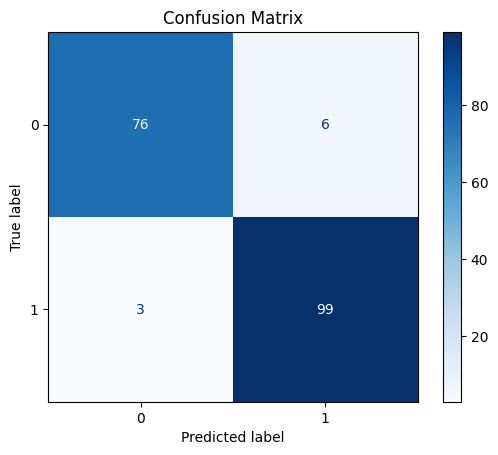

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## predict: predictions with test data:
y_pred = knn.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")    
plt.title("Confusion Matrix")
plt.show()

## Explanation:

TN (True Negative): The model predicted 0 and the actual label was 0 → correct prediction of negative.

FN (False Negative): The model predicted 0 but the actual label was 1 → "detection failure".

FP (False Positive): The model predicted 1 but the actual label was 0 → "false alarm".

TP (True Positive): The model predicted 1 and the actual label was 1 → correct prediction of positive.


| Real \ predicted | 0 (predicted) | 1 (predicted) |
|-----------------|--------------|--------------|
| 0 (Real)        | TN           | FP           |
| 1 (Real)        | FN           | TP           |


In [39]:
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[76  6]
 [ 3 99]]


In [40]:
print("\n Classification Report: \n" , classification_report(y_test, y_pred))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.93      0.94        82
           1       0.94      0.97      0.96       102

    accuracy                           0.95       184
   macro avg       0.95      0.95      0.95       184
weighted avg       0.95      0.95      0.95       184



# EXPLANATION 1
### After oneHotEncoder
### Only with numeric variables

# KNN Analysis (based on pdf 06-FT03)
``` knn = KNeighborsClassifier(n_neighbors=5) ```

In the first application with default hyperparameters and a cluster count of 5, we obtained:

**Total sample size: 918 rows (100%)**

- TN (True Negative): 76% 
- FP (False Positive): 6% 
- FN (False Negative): 3% 
- TP (True Positive): 99% 


In other words, more than 175% of the total TN + TP (76% TN + 99% TP) of our model trained correctly.

Conversely, we had 3 (FN) lines of the sample incorrectly classified; in the case of this problem, which could be fatal, we will consider it a failure in disease detection (FN) by the model.

As an area for improvement: reduce the 'False Negatives'.

* Regarding other metrics:


1. Accuracy: We obtained *0.936*, which we can consider excellent for the model, as it managed to predict 94% of the cases in the sample. However, it is important to adjust it to include the remaining 3% (FN) as TP.

Best parameters: {'knn__metric': 'manhattan', **'knn__n_neighbors': 11**, 'knn__weights': 'distance'}
Best accuracy (validation): 0.936
Accuracy in the test: 0.951



| Classe | Precision | Recall | F1-score | Support |
|--------|-----------|--------|----------|---------|
| 0      | 0.96      | 0.93   | 0.94     | 82      |
| 1      | 0.94      | 0.97   | 0.96     | 102     |
| **Accuracy** |           |        | **0.95** | 184     |
| **Macro avg** | 0.95      | 0.95   | 0.95     | 184     |
| **Weighted avg** | 0.95      | 0.95   | 0.95     | 184     |

Healthy people:
2. In the accuracy of positives and correct results, we had 96%, of which 4% are classified as imprecise, not 100% 'certain', such as 0 (they may or may not be healthy). In this case, they were marked as healthy but may be <u>sick</u>.

3. Recall = True Positives / (True Positives + False Negatives)
This means that of all the examples that were actually class 0, healthy people, the model was able to identify 93%, leaving only 7% as falsely healthy.

4. F-score
F1 = 2 * (precision * recall) / (precision + recall)
This means that this metric measures balance. It prevents a model with high recall and low precision (or vice versa) from looking good.
In short, we need to have both metrics balanced to actually have a model with good prediction.
f.Score = 94% and recall = 93% (we have balance)

Averages:
Macro Avg = 0.95 may represent an optimal model.
Weighted Avg = 0.95, similar to accuracy, therefore, we can say that the classes are balanced among themselves.
➡️ If weighted = accuracy, normally the classes are not very unbalanced.
Weighted Avg = 95% and comparing with accuracy = 94% (we have balance)

In conclusion, we found a critical area for potential future improvement:

1. Critical point for improvement, for recall in the class of sick people, positive for attack. We had a recall of 94%, meaning it failed to correctly predict 6% of the sick individuals, which can be fatal.

1.1 Suggested solution: improve the balancing of sick people (this was done, we applied OneHotEncoder), that is, increase the number of sick people in the model's training sample. To establish patterns for sick people, we need to confirm if we have more attributes that can better explain class 1 (sick people). DONE

1.2 We handled outliers with flag techniques, only treating original numeric variables from df_raw and not binary ones. DONE

Result: after improvements 1.1 and 1.2, the TP increased to 99% detection. The suggestion for a new application of KNN will be with 11K.

# ~~EXPLANATION 2~~ before oneHotEncoder
### Before oneHotEncoder
### With numeric + categorical variables transformed into numeric variables using OneHotEncoder
# KNN Analysis (based on pdf 06-FT03)
``` knn = KNeighborsClassifier(n_neighbors=5) ```

In the first application with standard hyperparameters and a cluster count of 5, we obtained:
TP (True Positive): 59 out of a total of 587 samples
TN (True Negative): 16 out of a total of 587 samples
FP (False Positive): 19 out of a total of 587 samples
FN (False Negative): 31 out of a total of 587 samples

That is, more than 50% of our model trained correctly. On the other hand, we had 31 lines of the sample incorrectly classified; in the case of this problem, it can be fatal, so we will consider it a failure in the model's disease detection.

Regarding other metrics:
1. Accuracy: we obtained *0.755*, which we can consider good for the model, as it managed to predict 70% of the cases in the sample. However, it is important to adjust it to include the remaining 30% as TP.

Best accuracy (validation): 0.755
Accuracy in the test: 0.703

Healthy people:

| Classe        | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| **0**         | 0.73      | 0.76   | 0.75     | 68      |
| **1**         | 0.66      | 0.62   | 0.64     | 50      |
| **Accuracy**  | —         | —      | 0.70     | 118     |
| **Macro Avg** | 0.70      | 0.69   | 0.69     | 118     |
| **Weighted Avg** | 0.70  | 0.70   | 0.70     | 118     |

2. In the Precision of positives, we had 73%.

3. Recall
Recall = True Positives / (True Positives + False Negatives)
This means that of all the examples that were actually class 0, healthy people, the model managed to identify 76%, leaving only 24% as false negatives.

4. F-score
F1 = 2 * (precision * recall) / (precision + recall)
This means that this metric measures balance. It prevents a model with high recall and low precision (or vice versa) from appearing good.

In short, we need to have both metrics balanced to actually have a model with good prediction.

Averages:
Macro Avg = 0.69 may represent a moderate model.
Weighted Avg = 0.70, similar to accuracy, therefore, we can say that the classes are balanced between them.

- If weighted = accuracy, then classes are usually not very unbalanced.

Conclusion
We found a critical point for possible future improvement:

1. Critical point for improvement, for recall in the class of sick people, positive for attack. We had a recall = 62%, meaning it failed to correctly predict 38% of the sick people, which can be fatal.

1.1 Suggested solution: improve the balancing of sick people, that is, increase the number of sick people in the model's training sample. As for the patterns of sick people, we need to confirm if we have more attributes that can better explain class 1 (sick people).  

# Optimize the number of neighbors with GridSearchCV

# Feature Scaling Pipeline

### Step 1 — StandardScaler
- Normalizes all features
- Assumes all are numerical
- Sets mean = 0 and standard deviation = 1

### Step 2 — KNeighborsClassifier
- Highly scale-sensitive model
- Distances dominate the decision

#### When is this pipeline appropriate?

- Fully numeric dataset
- PCA, KNN, K-Means, SVM
- Clean data without categorical variables
- Educational or exploratory notebooks

##### When is this pipeline inadequate?

- Dataset with categorical columns
- Mixed data (num + cat)
- Production
- Advanced feature engineering

##### In this  case:

>> It wouldn't be sufficient

>  It would break the semantics of categorical variables

>  It would generate errors or incorrect learning





In [41]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Feature Scaling Pipeline -> This pipeline is a didactic example of a feature scaling application, suitable only when all variables are numeric.
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Hiper parametros
param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]
}

# otimização de vizinhos
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5
)

grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
print(f"Best accuracy (validation): {grid.best_score_:.3f} ")

# best_model = grid.best_estimator_
# y_pred = best_model.predict(X_test_scaled)

# accuracy_score: percentage of correct classifications
test_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy in Test: {test_acc:.3f}")

Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best accuracy (validation): 0.936 
Accuracy in Test: 0.951


# Compare performance before and after optimization.

#  KNN Analysis (based on pdf 06-FT03)
## knowledge
``` knn = KNeighborsClassifier(n_neighbors=5) ```

In the first application with standard hyperparameters and a cluster count of 5, we obtained:
TP (True Positive): 59 out of a total of 587 samples
TN (True Negative): 16 out of a total of 587 samples
FP (False Positive): 19 out of a total of 587 samples
FN (False Negative): 31 out of a total of 587 samples

That is, more than 50% of our model trained correctly. On the other hand, we had 31 lines of the sample incorrectly classified; in the case of the problem in question, this could be fatal, so we will consider it a failure in the model's disease detection.

Regarding other metrics:
1. Accuracy: we obtained *0.755*, which we can consider good for the model, as it managed to predict 70% of the cases in the sample. However, it is important to adjust it to include the remaining 30% as false positives.

Healthy people:
2. In the Accuracy of positives, and it is correct, we had 73%.

3. Recall
Recall = True Positives / (True Positives + False Negatives)
This means that of all the examples that were actually class 0, healthy people, the model managed to identify 76%, leaving only 24% as false negatives.

4. F-score
F1 = 2 * (precision * recall) / (precision + recall)
This means that this metric measures balance. It prevents a model with high recall and low precision (or vice versa) from appearing good.
In short, we need to have both metrics balanced to actually have a model with good prediction.

Averages:
Macro Avg = 0.69 may represent a moderate model.
Weighted Avg = 0.70, similar to accuracy, therefore, we can say that the classes are balanced among themselves.

➡️ If weighted = accuracy, normally the classes are not very unbalanced.

Conclusion
We found a critical point for possible future improvement:

1. Critical point for improvement, for recall in the class of sick people, positive for attack. We had a recall = 62%, meaning it failed to correctly predict 38% of the sick people, which can be fatal.

1.1 Suggested solution: improve the balancing of sick people, that is, increase the number of sick people in the model's training sample. As for the patterns of sick people, we need to confirm if we have more attributes that can better explain class 1 (sick people).

# CONTEXT FOR explanation:
TP (True Positive): The model predicted 1 and the actual label was 1 → correct prediction of positive.

TN (True Negative): The model predicted 0 and the actual label was 0 → correct prediction of negative.

FP (False Positive): The model predicted 1 but the actual label was 0 → "false alarm".

FN (False Negative): The model predicted 0 but the actual label was 1 → "detection failure".


| Real \ predicted | 0 (predicted) | 1 (predicted) |
|-----------------|--------------|--------------|
| 0 (Real)        | TN           | FP           |
| 1 (Real)        | FN           | TP           |


#  classification_report result
Classification Report:

Class 0 => Healthy (false)

Class 1 => Sick (positive)

# without oneHotEncoder

| Class         | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| **0**         | 0.73      | 0.76   | 0.75     | 68      |
| **1**         | 0.66      | 0.62   | 0.64     | 50      |
| **Accuracy**  | —         | —      | 0.70     | 118     |
| **Macro Avg** | 0.70      | 0.69   | 0.69     | 118     |
| **Weighted Avg** | 0.70  | 0.70   | 0.70     | 118     |


# with oneHotEncoder
| Class         | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| **0**         | 0.97      | 0.87   | 0.91     | 68      |
| **1**         | 0.84      | 0.96   | 0.90     | 50      |
| **Accuracy**  | —         | —      | 0.91     | 118     |
| **Macro Avg** | 0.90      | 0.91   | 0.91     | 118     |
| **Weighted Avg** | 0.91  | 0.91   | 0.91     | 118     |


# Predicting the condition of a new patient
*with fictitious values

# Understanding the fields:
| Field | Description | Example | Type | In full / Meaning |
|-----------------|--------------------------------------------------------------|---------|-------------|-------------------------------------------------------------|
| Age | Patient's age | 55 | numeric | 55 years |
| Sex | Patient's sex | M | categorical | M = male, F = female |
| ChestPainType | Type of chest pain | ATA | categorical | ATA = atypical angina; ASY = asymptomatic; TA = typical; NAP = non-anginal |
| RestingBP | Resting blood pressure (mm Hg) | 130 | numeric | 130 mm Hg |
| Cholesterol | Total serum cholesterol (mg/dl) | 245 | numeric | 245 mg/dl |
| FastingBS | Fasting blood glucose > 120 mg/dl? | 0 | | categorical | 0 = normal; 1 = high (above 120 mg/dl) |
| Resting ECG | Resting electrocardiogram result | ST | categorical | Normal / ST-T anomaly / Left ventricular hypertrophy |
| MaxHR | Maximum heart rate reached | 150 | numerical | 150 bpm |
| Exercise Angina | Exercise-induced angina | N | categorical | N = no; Y = angina present |
| Oldpeak | ST segment depression due to exercise | 1.0 | numerical | ST depression of 1.0 mm |
| ST_Slope | ST segment slope at peak exercise | Down | categorical | Up = rise; Flat = flat; Down = fall |
| Heart Disease | Presence of heart disease (TARGET) | 1 | categorical | 1 = has heart disease; 0 = does not have |

Reapply the model, filtering the original columns and using the columns that have been processed to identify outliers.

# knowledge
* Among people experienced in Data Stewardship (focused on governance + explainability + robustness), the most recommended option is usually:

- Use _capped + _outlier_flag and NOT use the original (uncapped) columns in the model.

(equivalent to your Option A, but “without duplicating” the same variable twice.)

Why is this the most advocated?

- Robustness: the model doesn't “explode” due to extreme values.

- Explainability: the flag clearly states “this case was extreme”.

- Governance: it becomes transparent what was handled and when (useful for audits and stakeholders).

- Less noise: avoiding keeping original + capped together reduces collinearity and confusion in interpretation.

When would I NOT recommend this option?

- If the outlier is a rare but highly informative event (e.g., fraud, real spikes) and you want the model to “feel” the full magnitude. You can keep the original one as well — but that's a conscious decision, not a standard one.
# Recommended: Use `_capped + _outlier_flag` and remove the original continuous columns.
target = "HeartDisease"
orig_continuous = ["RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

capped_cols = [c for c in df_encoded.columns if c.endswith("_capped")]
flag_cols  = [c for c in df_encoded.columns if c.endswith("_outlier_flag")]

# # base = everything that is not target, not original continuous, not capped/flagged
base_cols = [
    c for c in df_encoded.columns
    if c != target
    and c not in orig_continuous
    and not c.endswith("_capped")
    and not c.endswith("_outlier_flag")
]

X = df_encoded[base_cols + capped_cols + flag_cols]
y = df_encoded[target]


In [42]:
# Recommended: Use `_capped + _outlier_flag` and remove the original continuous columns.
target = "HeartDisease"
orig_continuous = ["RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

capped_cols = [c for c in df_encoded.columns if c.endswith("_capped")]
flag_cols  = [c for c in df_encoded.columns if c.endswith("_outlier_flag")]

# # base = everything that is not target, not original continuous, not capped/flagged
base_cols = [
    c for c in df_encoded.columns
    if c != target
    and c not in orig_continuous
    and not c.endswith("_capped")
    and not c.endswith("_outlier_flag")
]

X = df_encoded[base_cols + capped_cols + flag_cols]
y = df_encoded[target]


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_scaled, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",11
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [44]:
# classification 
y_train.value_counts()

HeartDisease
1    406
0    328
Name: count, dtype: int64

In [45]:
print(y_train.value_counts())
print(y_test.value_counts())

HeartDisease
1    406
0    328
Name: count, dtype: int64
HeartDisease
1    102
0     82
Name: count, dtype: int64


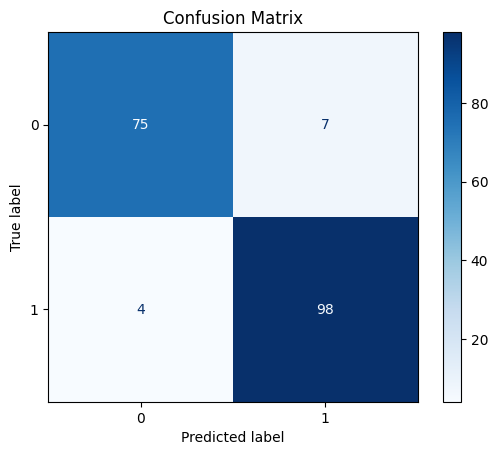

In [46]:
# predict: predict with Test Data
y_pred = knn.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")    
plt.title("Confusion Matrix")
plt.show()

| Real \ Predicted | 0 (Predicted) | 1 (Predicted) |
|-----------------|--------------|--------------|
| 0 (Real)        | TN           | FP           |
| 1 (Real)        | FN           | TP           |


In [47]:
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[75  7]
 [ 4 98]]


In [48]:
print("\n Classification Report:\n" , classification_report(y_test, y_pred))


 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        82
           1       0.93      0.96      0.95       102

    accuracy                           0.94       184
   macro avg       0.94      0.94      0.94       184
weighted avg       0.94      0.94      0.94       184



# OPTIMIZATION GRID SEARCH CV

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#pipeline
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Hyperparameters
param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]
}

# Neighbor optimization
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5
)

grid.fit(X_train_scaled, y_train)

print("BEST Hyperparameters:", grid.best_params_)
print(f"BEST accuracy (VALIDATION): {grid.best_score_:.3f} ")

# best_model = grid.best_estimator_
# y_pred = best_model.predict(X_test_scaled)

# accuracy_score: percentage of correct classifications
test_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy in Test: {test_acc:.3f}")

BEST Hyperparameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
BEST accuracy (VALIDATION): 0.936 
Accuracy in Test: 0.940


# New Prediction

In [50]:
X_train.columns

Index(['Age', 'FastingBS', 'Sex_F', 'Sex_M', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST',
       'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up', 'RestingBP_capped',
       'Cholesterol_capped', 'MaxHR_capped', 'Oldpeak_capped',
       'RestingBP_outlier_flag', 'Cholesterol_outlier_flag',
       'MaxHR_outlier_flag', 'Oldpeak_outlier_flag'],
      dtype='str')

In [51]:
X_train.head(1)

,Age,FastingBS,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,...,ST_Slope_Flat,ST_Slope_Up,RestingBP_capped,Cholesterol_capped,MaxHR_capped,Oldpeak_capped,RestingBP_outlier_flag,Cholesterol_outlier_flag,MaxHR_outlier_flag,Oldpeak_outlier_flag
485,63,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,139,217.0,128,1.2,0,0,0,0


In [52]:
df_encoded.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'RestingBP_outlier_flag', 'RestingBP_capped',
       'Cholesterol_outlier_flag', 'Cholesterol_capped', 'MaxHR_outlier_flag',
       'MaxHR_capped', 'Oldpeak_outlier_flag', 'Oldpeak_capped', 'Sex_F',
       'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal',
       'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y',
       'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up', 'HeartDisease'],
      dtype='str')

In [53]:
import pandas as pd


# 0) New Patient
new_patient = pd.DataFrame([{
    "Age": 58,
    "Sex": "M",
    "ChestPainType": "ATA",
    "RestingBP": 138,
    "Cholesterol": 240,
    "FastingBS": 0,
    "RestingECG": "ST",
    "MaxHR": 160,
    "ExerciseAngina": "N",
    "Oldpeak": 1.4,
    "ST_Slope": "Flat"
}])


# 1) One-hot encoding (use the SAME encoder already fitted)
df_categorical = new_patient.select_dtypes(exclude=["number"])
encoded_arr = encoder.transform(df_categorical)

encoded_df_new = pd.DataFrame(
    encoded_arr,
    columns=encoder.get_feature_names_out(df_categorical.columns),
    index=new_patient.index
)


# 2) Numerical + capped/flags (use the SAME iqr_limits as the training)
df_numeric = new_patient.select_dtypes(include=["number"]).copy()

for col in ["RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]:
    low, high = iqr_limits[col]
    df_numeric[f"{col}_outlier_flag"] = ((df_numeric[col] < low) | (df_numeric[col] > high)).astype(int)
    df_numeric[f"{col}_capped"] = df_numeric[col].clip(lower=low, upper=high)

df_numeric_final = df_numeric[[
    "Age", "FastingBS",
    "RestingBP_capped", "Cholesterol_capped", "MaxHR_capped", "Oldpeak_capped",
    "RestingBP_outlier_flag", "Cholesterol_outlier_flag", "MaxHR_outlier_flag", "Oldpeak_outlier_flag"
]]


# 3) Assemble X of the new patient and align it with the training columns.
new_X = pd.concat([df_numeric_final, encoded_df_new], axis=1)

# # align with the columns that the model expects (X_train.columns)
new_X = new_X.reindex(columns=X_train.columns, fill_value=0)


#4) Scale with the SAME scaler (align with the scaler columns)
if hasattr(scaler, "feature_names_in_"):
    cols_scaler = list(scaler.feature_names_in_)
else:
    cols_scaler = list(X_train.columns)  ## fallback: use the training order

new_X_for_scaler = new_X.reindex(columns=cols_scaler, fill_value=0)
new_X_scaled = scaler.transform(new_X_for_scaler)


#5) Prediction with the trained model (GridSearchCV)
predict_new_patient = grid.predict(new_X_scaled)

print(predict_new_patient[0])
print(f"Predicted risk: {'Sick' if predict_new_patient[0] == 1 else 'Healthy'}")


0
Predicted risk: Healthy


In [56]:
# save model to deploy into PROD
import joblib
joblib.dump(grid, "./deploy-prod/heart_disease_pipeline_with_outliers_treated.joblib")

model = joblib.load("./deploy-prod/heart_disease_pipeline_with_outliers_treated.joblib")

In [58]:
import pandas as pd

pred = model.predict(new_X_scaled)

print("Patient Sick" if pred[0] == 1 else "Healthy")

Healthy
